In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from os import listdir, makedirs
import ast
import pickle

In [2]:
# Data location
PROJECT_PATH = '/Users/euanprentis/Documents/feat_predict_simulations/exp-1_noev'
DATA_PATH = f'{PROJECT_PATH}/data'
RESULTS_PATH = f'{PROJECT_PATH}/results'
TRANSITION_RESULTS_DIR = 'transition-influence/training'
FIG_PATH = f'{PROJECT_PATH}/figs'

# Model info
MODELS = [d for d in listdir(DATA_PATH) if d[0] != '.']

TRANSITION_INFLUENCE_COLORS = {
    'incidental': '#F52342',
    'true': '#FFBC42'
}

In [3]:
# Mkae figure path if it does not exist
makedirs(FIG_PATH, exist_ok=True)

# Functions

## Helper Functions

In [4]:
def load_data_from_dir(dpath):
    """
    Load data from a directory into a single pandas DataFrame
    
    Arguments
    ---------
    dpath : str
        path to data directory
        
    Returns
    -------
    data : pd.DataFrame
        phase data
    """
    data = []
    for f in listdir(dpath):
        if f.startswith('.'):
            continue
        data.append(pd.read_csv(f'{dpath}/{f}'))
    data = pd.concat(data)
    return data

def information_from_label(model_label):
    """
    Get field information from model label

    Arguments
    ---------
    model_label : str
        model label
    
    Returns
    -------
    fields
    """
    fields = {}
    for field in model_label.split('_'):
        if not '-' in field:
            continue
        key, value = field.split('-')
        fields[key] = value
    return fields

def convert_states_to_labels(states):
    """
    Convert array of states to string labels

    Arguments
    ---------
    states : np.ndarray
        Array represent states by their features

    Returns
    -------
    labels : list
        state labels
    """
    labels = [''.join(label) for label in states.astype(str)]
    return labels

def standardize_reps_order(reps):
    """
    Standardize the order of representations

    Arguments
    ---------
    reps : dict
        representation dictionary

    Returns
    -------
    reps : dict
        standardized representation dictionary
    """
    
    # Get indices for standardized ordering
    idx_sorted_S = np.lexsort(reps['S'].T[::-1])
    idx_sorted_F = np.lexsort(reps['F_raw'].T[::-1])
    S = reps['S'][idx_sorted_S]
    F_raw = reps['F_raw'][idx_sorted_F]

    # Re-order rows by whether starts are conjunctive or not
    if reps['agent_info']['conjunctive_starts']:
        M = reps['M'][idx_sorted_S]
        bias = reps['bias'][idx_sorted_S]
        row_labels = convert_states_to_labels(S)
    else:
        M = reps['M'][idx_sorted_F]
        bias = reps['bias'][idx_sorted_F]
        row_labels = convert_states_to_labels(F_raw)

    # Re-order columns by whether successors are conjunctive or not
    if reps['agent_info']['conjunctive_successors']:
        M = M.T[idx_sorted_S].T
        bias = bias.T[idx_sorted_S].T
        col_labels = convert_states_to_labels(S)
    else:
        M = M.T[idx_sorted_F].T
        bias = bias.T[idx_sorted_F].T
        col_labels = convert_states_to_labels(F_raw)

    # Assign re-ordered representations
    reps['S'] = S
    reps['F_raw'] = F_raw
    reps['M'] = M
    reps['bias'] = bias
    reps['row_labels'] = row_labels
    reps['col_labels'] = col_labels

    return reps

def set_axis_ratio(ax, ratio=1):
    """
    Make axis aspect ratio square
    
    Arguments
    ---------
    ax : matplotlib.Axes
        matplotlib axis to transform
    ratio : int or float
        ratio of y- to x-axis
        
    Returns
    -------
    None
    """
    ax.set_aspect(ratio/ax.get_data_ratio(), adjustable='box')

def round_interval_labels(interval_series, n):
    """
    Round interval labels to n decimal places

    Arguments
    ---------
    interval_series : pd.Series
        series of pandas Interval objects
    
    Returns
    -------
    interval_series : pd.Series
        series of pandas Interval objects with rounded labels
    """
    return interval_series.apply(
        lambda x: pd.Interval(
            np.abs(round(x.left, n)),
            np.abs(round(x.right, n))
        )
    )

def bin_params(params, n_bins, method=pd.cut):
    """
    Bin parameters into n_bins

    Arguments
    ---------
    params : np.ndarray
        parameter values
    n_bins : int
        number of bins
    
    Returns
    -------
    params_binned : np.ndarray
        binned parameter values
    """
    params_binned = method(params, n_bins)
    params_binned = round_interval_labels(params_binned, 2)
    return params_binned



def convert_str_to_array(array_string):
    """
    Convert a string representation of an array to a numpy array

    Arguments
    ---------
    array_string : str
        String representation of an array
    
    Returns
    -------
    arr : numpy.Array
        Numpy array of string
    """
    array_string = array_string.replace('\n', '')
    array_string = array_string.replace('[ ', '[')
    array_string = array_string.replace('  ', ',')
    array_string = array_string.replace(' ', ',')
    arr = ast.literal_eval(array_string)
    arr = np.array(arr)
    return arr

def get_target_frequency(df):

    # Get rates of each target per model and id
    target_counts = df.groupby(
        ['id', 'model_label', 'target']
        ).size().reset_index(name='count')
    total_counts = target_counts.groupby(
        ['id', 'model_label']
        )['count'].transform('sum')
    target_counts['rate'] = target_counts['count']/total_counts

    # Find the highest and lowest rates per id and model
    highest_rate = target_counts.groupby(
        ['id', 'model_label']
        )['rate'].transform('max')

    # Categorize each item
    target_counts['freq_target'] = target_counts['rate'] == highest_rate
    target_counts['freq_target'] = target_counts['freq_target'].astype(int)
    df = pd.merge(
        df,
        target_counts,
    )

    return df

## Plot Functions

In [5]:
def plot_training_curve(
        df,
        y,
        grouping_var,
        palette = 'rocket',
        hue_order = None,
        title = None,
        legend_title = None):
    """
    Plot training curve

    Arguments
    ---------
    df : pd.DataFrame
        training data
    y : str
        variable to plot on y-axis ('reward' or 'p')
    grouping_var : str
        variable to group by
    
    palette : list
        color palette
    title : str
        title for plot
    legend_title : str
        title for legend
    
    Returns
    -------
    None
    """
    fig, ax = plt.subplots(figsize=(6, 3))
    blocks = df['block'].unique()
    if len(blocks) > 1:
        ax.axvline(np.max(df['trial'])/len(blocks), color='black')
    for block in blocks:
        idx = df['block'] == block
        sns.lineplot(
            data = df.loc[idx],
            x = 'trial',
            y = y,
            hue = grouping_var,
            palette = palette,
            hue_order = hue_order,
            ci = None
        )
    n_labels = len(df[grouping_var].unique())
    handles, labels = plt.gca().get_legend_handles_labels()
    ax.legend(
        handles[-n_labels:],
        labels[-n_labels:],
        title = legend_title,
        loc = (1.05, .45)
    )
    ax.set_xlabel('Trial')
    if y == 'reward':
        max_reward = np.max(df['reward'])
        ax.axhline(max_reward/2, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Reward')
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.axhline(.25, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('P(Choice)')
        ax.set_ylim(0, 1)
    elif y == 'resid':
        ax.axhline(.72, color='black', linestyle='--', zorder=0)
        ax.set_ylabel('Residual')
        ax.set_ylim(0, 1)
    ax.set_title(title, loc='left')

def plot_param_interaction(
        df,
        continous_param,
        binned_param,
        y,
        title = None,
        legend_title = None,
        xlabel = None,
        ylabel = None,
        palette = 'rocket'
):
    
    # Get average reward by alpha and segmentation bin
    plot_df = df[['id', continous_param, binned_param, y]]
    plot_df = plot_df.groupby(['id', continous_param, binned_param])
    plot_df = plot_df.mean().reset_index()

    # Y-intercept of chance line
    if y == 'reward':
        max_reward = np.max(df['reward'])
        chance = max_reward/2
    elif y == 'p':
        chance = .25
    elif y == 'coef':
        chance = 0
    
    # Plot
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(chance, color='black', linestyle='--', zorder=0)
    n_bins = len(plot_df[binned_param].unique())
    for i, param_bin in enumerate(plot_df[binned_param].unique()):
        idx = plot_df[binned_param] == param_bin
        sns.regplot(
            data = plot_df.loc[idx],
            x = continous_param,
            y = y,
            scatter = False,
            color = sns.color_palette(palette, n_bins)[i],
            label = param_bin
        )
    ax.legend(title=legend_title, loc=(1.05, .45))
    if y == 'reward':
        ax.set_ylim(None, max_reward)
    elif y == 'p':
        ax.set_ylim(0, 1)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc='left')
    set_axis_ratio(ax)

# Load Data

## Training

In [6]:
# Load training data
training_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/training')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    training_df.append(model_df)
training_df = pd.concat(training_df)
training_df = training_df.reset_index(drop=True)
training_df['block'] = 1
training_df = get_target_frequency(training_df)
training_df['depth'] = training_df['depth'].astype(int)
training_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,model,bias,sdim,depth,freq,pairs,block,count,rate,freq_target
0,161,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,ff,none,2,3,uniform,fact,1,135,0.125000,1
1,161,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,ff,none,2,3,uniform,fact,1,135,0.125000,1
2,161,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,ff,none,2,3,uniform,fact,1,135,0.125000,1
3,161,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,ff,none,2,3,uniform,fact,1,135,0.125000,1
4,161,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.645778,0,8.389189,8.389189,1,0,1.329290,False,...,ff,none,2,3,uniform,fact,1,135,0.125000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15119995,187,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,ff,none,2,4,nonuniform,nonfact,1,60,0.055556,1
15119996,187,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,ff,none,2,4,nonuniform,nonfact,1,60,0.055556,1
15119997,187,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,ff,none,2,4,nonuniform,nonfact,1,60,0.055556,1
15119998,187,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.351090,0,0.173653,0.173653,1,0,1.162702,False,...,ff,none,2,4,nonuniform,nonfact,1,30,0.027778,0


## Test

In [101]:
test_df = []
for model in MODELS:
    model_df = load_data_from_dir(f'{DATA_PATH}/{model}/test')
    model_info = information_from_label(model)
    for key, value in model_info.items():
        model_df[key] = value
    test_df.append(model_df)
test_df = pd.concat(test_df)
test_df = test_df.reset_index(drop=True)
test_df['depth'] = test_df['depth'].astype(int)
test_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,successor,p,reward,correct,model,bias,sdim,depth,freq,pairs
0,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[1 1 0 0],0.250000,0,0,ff,none,2,3,uniform,fact
1,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[1 8 0 0],0.250000,0,0,ff,none,2,3,uniform,fact
2,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[8 8 0 0],0.250000,0,0,ff,none,2,3,uniform,fact
3,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[1 8 0 0],0.250000,0,0,ff,none,2,3,uniform,fact
4,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,[8 8 0 0],0.094160,0,0,ff,none,2,3,uniform,fact
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759995,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[0 0 1 1],1.000000,0,0,ff,none,2,4,nonuniform,nonfact
1759996,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[ 0 0 1 10],0.179002,0,0,ff,none,2,4,nonuniform,nonfact
1759997,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[ 0 0 10 10],1.000000,0,0,ff,none,2,4,nonuniform,nonfact
1759998,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,[0 0 1 1],1.000000,0,0,ff,none,2,4,nonuniform,nonfact


## Representations

In [8]:
representations = {}
for model in MODELS:
    model_info = information_from_label(model)
    for fname in listdir(f'{DATA_PATH}/{model}/representations'):
        if fname.startswith('.'):
            continue
        agent_id = int(fname.split('_')[1].replace('.pkl', ''))
        with open(f'{DATA_PATH}/{model}/representations/{fname}', 'rb') as f:
            representations[model, agent_id] = standardize_reps_order(
                pickle.load(f)
            )
            for key, value in model_info.items():
                representations[model, agent_id][key] = value
            representations[model, agent_id]['edim'] =  4

## Subject Information 

In [9]:
subj_df = test_df[[
    'id',
    'model_label',
    'sdim',
    'depth',
    'freq',
    'pairs',
    'bias',
    'alpha',
    'beta',
    'gamma'
]]
subj_df = subj_df.drop_duplicates()
subj_df = subj_df.reset_index(drop=True)
subj_df

,id,model_label,sdim,depth,freq,pairs,bias,alpha,beta,gamma
0,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,2,3,uniform,fact,none,0.746698,0.086250,1
1,144,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,2,3,uniform,fact,none,0.108021,19.645513,1
2,178,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,2,3,uniform,fact,none,0.625936,1.260263,1
3,193,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,2,3,uniform,fact,none,0.042470,191.490773,1
4,187,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,2,3,uniform,fact,none,0.351090,0.173653,1
...,...,...,...,...,...,...,...,...,...,...
12995,203,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,2,4,nonuniform,nonfact,none,0.484746,1.032704,1
12996,12,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,2,4,nonuniform,nonfact,none,0.120530,3.089785,1
12997,161,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,2,4,nonuniform,nonfact,none,0.645778,8.389189,1
12998,175,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,2,4,nonuniform,nonfact,none,0.664033,13.996385,1


## Transition Influence

### Results

In [45]:
trans_influence_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/agent'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        agent_id = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'id': agent_id,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_df.append(coefs_df)

trans_influence_df = pd.concat(trans_influence_df)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Convert to long
trans_influence_df = pd.melt(
    trans_influence_df,
    id_vars = ['model_label', 'id', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_df = trans_influence_df.reset_index(drop=True)

# Add parameter information

trans_influence_df = pd.merge(
    trans_influence_df,
    subj_df,
    on = ['model_label', 'id']
)

trans_influence_df

,model_label,id,action,transition,coef,sdim,depth,freq,pairs,bias,alpha,beta,gamma
0,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,1,incidental,1.159,2,3,uniform,fact,none,0.505428,0.081583,1
1,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,2,incidental,0.710,2,3,uniform,fact,none,0.505428,0.081583,1
2,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,228,3,incidental,1.294,2,3,uniform,fact,none,0.505428,0.081583,1
3,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,214,1,incidental,2.042,2,3,uniform,fact,none,0.429925,0.392467,1
4,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,214,2,incidental,1.922,2,3,uniform,fact,none,0.429925,0.392467,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22477,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,225,2,true,2.983,2,4,nonuniform,nonfact,none,0.765853,0.710036,1
22478,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,225,3,true,2.714,2,4,nonuniform,nonfact,none,0.765853,0.710036,1
22479,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,231,1,true,2.110,2,4,nonuniform,nonfact,none,0.379396,0.181598,1
22480,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,231,2,true,1.893,2,4,nonuniform,nonfact,none,0.379396,0.181598,1


In [17]:
trans_influence_trial_df = []
for group_label in listdir(RESULTS_PATH):
    if group_label.startswith('.'):
        continue
    this_path = f'{RESULTS_PATH}/{group_label}/transition-influence/training/trial'
    for fname in listdir(this_path):
        if fname.startswith('.'):
            continue
        
        # Get agent ID from file name
        trial = int(fname.replace('.pkl', '').split('_')[1])

        # Load trace
        with open(f'{this_path}/{fname}', 'rb') as f:
            trace = pickle.load(f)

        # Extract coefficients
        coefs = az.summary(trace)['mean'].values
        n_actions = int(len(coefs)/2)
        coefs = coefs.reshape(-1, 2)
        
        # Add to full results set
        try:
            coefs_df = pd.DataFrame({
                'model_label': group_label,
                'trial': trial,
                'action': np.arange(1, n_actions + 1),
                'incidental': coefs[:, 0],
                'true': coefs[:, 1]
            })

        except:
            print('Error with agent:', agent_id)
            continue


        trans_influence_trial_df.append(coefs_df)

trans_influence_trial_df = pd.concat(trans_influence_trial_df)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Convert to long
trans_influence_trial_df = pd.melt(
    trans_influence_trial_df,
    id_vars = ['model_label', 'trial', 'action'],
    value_vars = ['incidental', 'true'],
    var_name = 'transition',
    value_name = 'coef'
)
trans_influence_trial_df = trans_influence_trial_df.reset_index(drop=True)

# Add parameter information
trans_influence_trial_df = pd.merge(
    trans_influence_trial_df,
    subj_df[['model_label', 'depth', 'freq', 'pairs']].drop_duplicates(),
    on = ['model_label']
)

trans_influence_trial_df

KeyboardInterrupt: 

In [16]:
def plot_successor_matrices(
        average_M,
        sdim = '2',
        freq = 'uniform',
        pairs = 'fact'
        ):
    """
    Plot successor matrices for a given agent

    Arguments
    ---------
    average_M : dict
        AVerage M per model_label
    sdim : str
        State dimensionality
    freq : str
        Environment state frequency type: 'uniform' or 'biased'
    pairs : str
        State pairing type: 'fact' or 'nonfact'
    
    Returns
    -------
    None
    """
    
    # Get combination of environment parameters to plot by
    bias_levels = ['true', 'none', 'incidental']
    depth_levels = [1, 2, 3, 4]

    # Get combination of environment parameters to plot by
    env_params = []
    for bias in bias_levels:
        for depth in depth_levels:
            env_params.append([bias, depth])

    # Plot successor matrices
    n_rows = len(bias_levels)
    n_cols = len(depth_levels)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3))
    empty_label = 'model-ff_bias-{}_sdim-{}_depth-{}_freq-{}_pairs-{}'
    for i in range(len(env_params)):
        bias, depth = env_params[i]
        model = empty_label.format(bias, sdim, depth, freq, pairs)
        ax = axs[i//n_cols, i%n_cols]
        ax.imshow(average_M[model], cmap='rocket')
        depth = representations[model, agent_id]['depth']
        ax.set_title(f'Bias = {bias}, Env Depth = {depth}')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.suptitle(f'Average Successor Matrices (freq = {freq}, pairs = {pairs})')
    fig.tight_layout()

In [ ]:
# Get average successor representation for each simulation group
average_M = {model: [] for model in MODELS}
for key in representations.keys():
    M = representations[key]['M']
    if len(M) in [16, 24, 32, 40]:
        average_M[key[0]].append(M)

# Average across M matrices for each segmentation bin
average_M = {
    model: np.mean(average_M[model], axis=0)
    for model in MODELS
}

{'model-ff_bias-none_sdim-2_depth-3_freq-uniform_pairs-fact': array([[139.76839591,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 69.38808735,   0.99222121,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 65.54102144,   0.49328536,   0.99222121, ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.99353267,
           0.49504415,  65.1256037 ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.99353267,  69.40100036],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        , 139.7955334 ]]),
 'model-ff_bias-none_sdim-2_depth-4_freq-nonuniform_pairs-fact': array([[133.61367723,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 66.31016247,   0.99335229,   0.        , ...,   0.        ,
           0.        ,   0.       

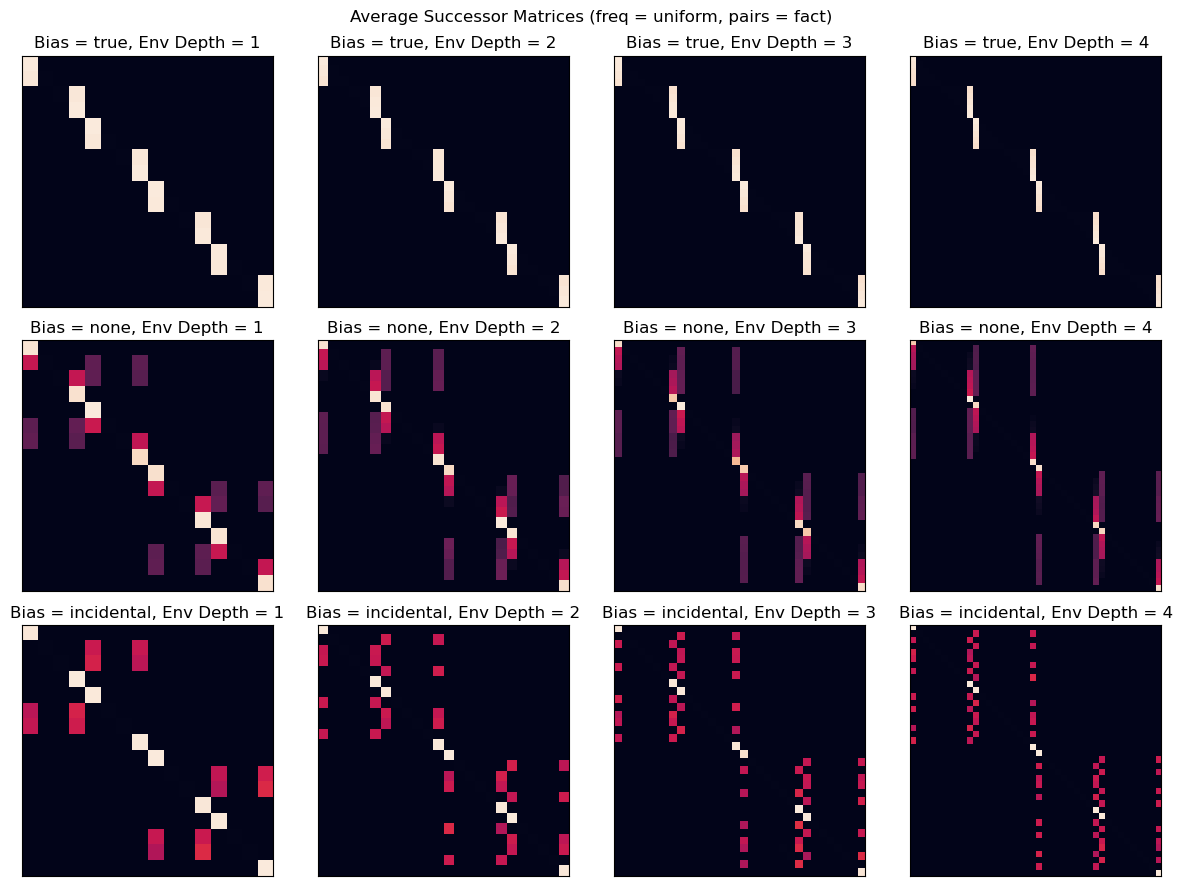

In [17]:
plot_successor_matrices(average_M, freq='uniform', pairs='fact')

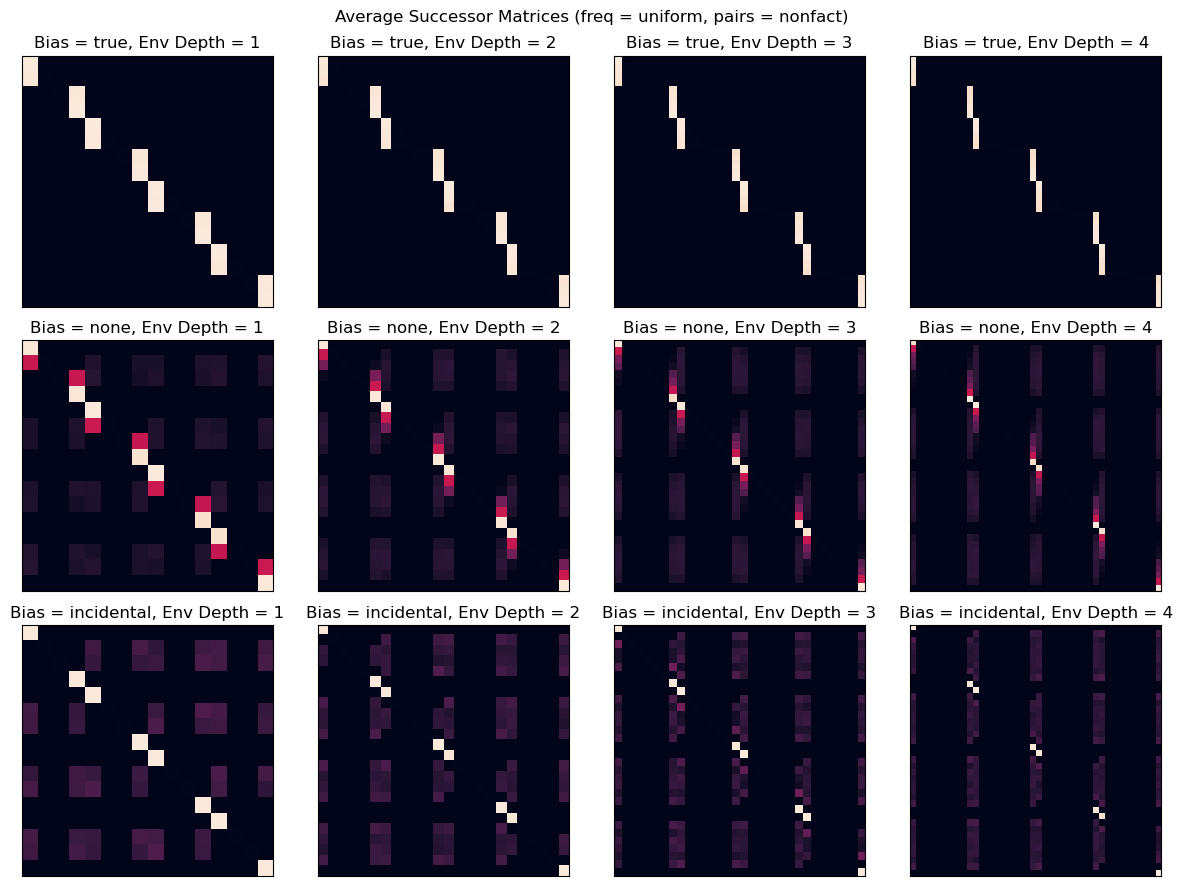

In [18]:
plot_successor_matrices(average_M, freq='uniform', pairs='nonfact')

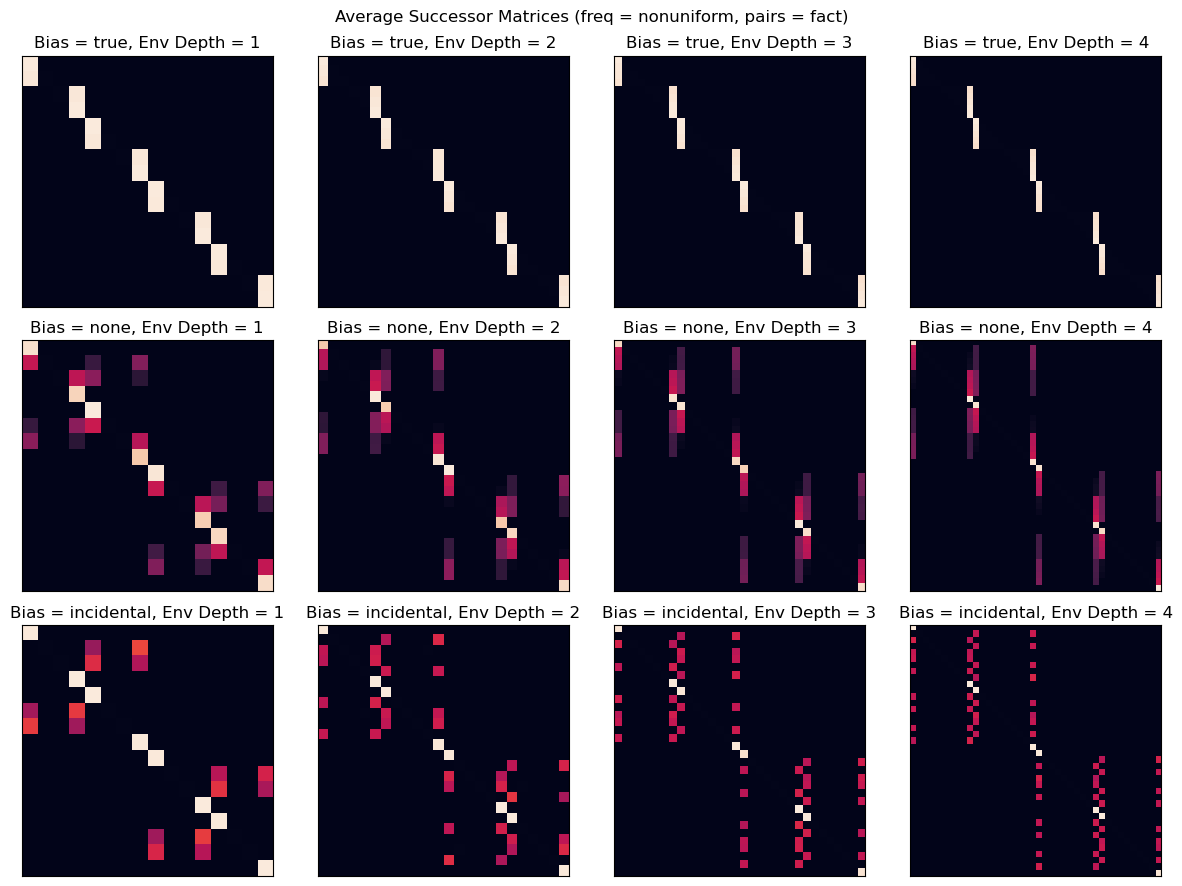

In [19]:
plot_successor_matrices(average_M, freq='nonuniform', pairs='fact')

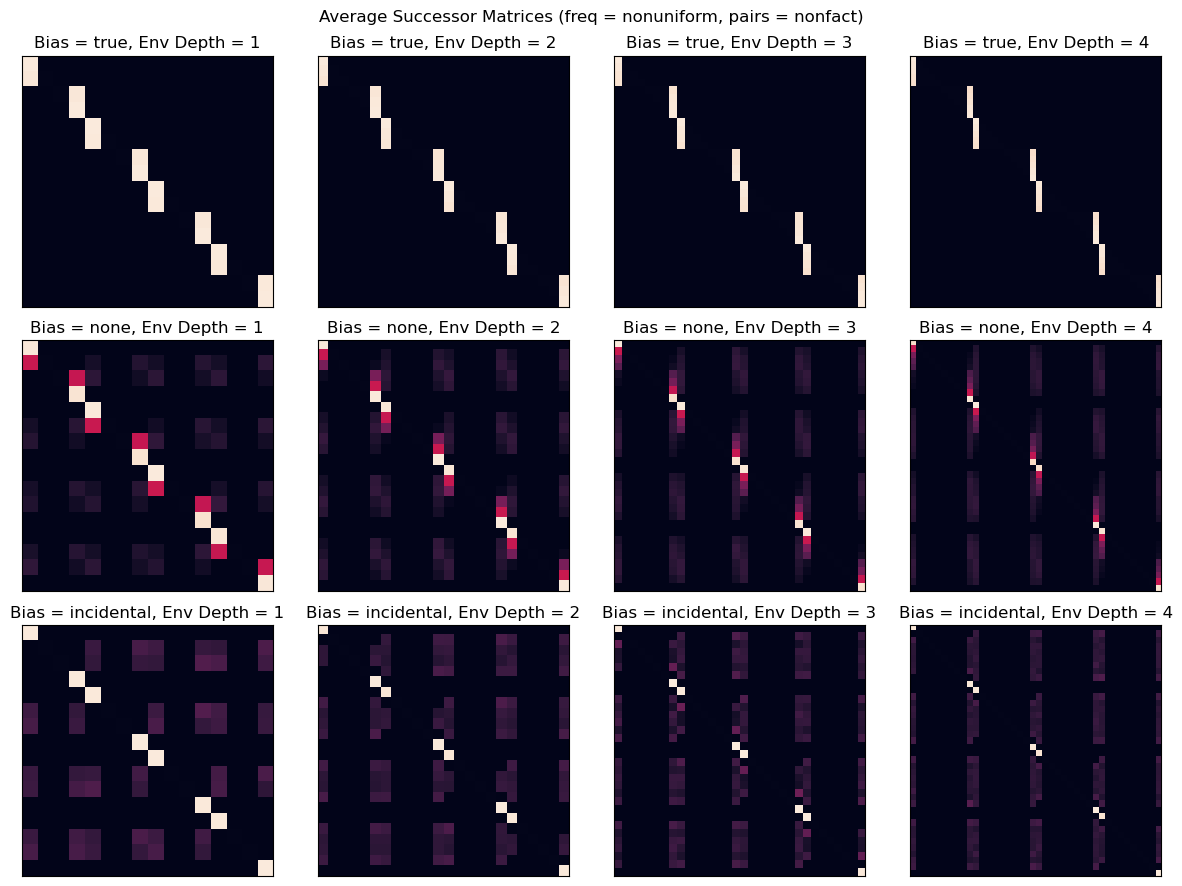

In [20]:
plot_successor_matrices(average_M, freq='nonuniform', pairs='nonfact')

In [24]:


def rsa(representations, sdim='2', freq='uniform', pairs='fact'):


    # Get all unique agent IDs
    agent_ids = np.array(list(representations.keys()))[:, 1].astype(int)
    agent_ids = np.unique(agent_ids)

    empty_label = 'model-ff_bias-{}_sdim-2_depth-{}_freq-{}_pairs-{}'
    results = []
    for depth in [1, 2, 3, 4]:
        for agent_id in agent_ids:
            
            # Get vectorized non-biased successor matrix
            model = empty_label.format('none', depth, freq, pairs)
            M = representations[model, agent_id]['M'].flatten()

            # Get vectorized true successor matrix 
            true_model = empty_label.format('true', depth, freq, pairs)
            M_true = representations[true_model, agent_id]['M'].flatten()

            # Get vectorized incidental successor matrix
            inci_model = empty_label.format('incidental', depth, freq, pairs)
            M_incidental = representations[inci_model, agent_id]['M'].flatten()
            
            # Fit linear model with true & incidental M as predictors
            X = np.vstack([M_true, M_incidental]).T
            coef = np.linalg.lstsq(X, M)[0]
            
            # Store results
            results.append({
                'id': agent_id,
                'model_label': model,
                'sdim': sdim,
                'freq': freq,
                'pairs': pairs,
                'depth': depth,
                'true': coef[0],
                'incidental': coef[1],
                'incidental_ratio': coef[1]/np.sum(coef),
                'abs_incidental_ratio': np.abs(coef[1])/np.sum(np.abs(coef))
            })

    # Convert to DataFrame
    results = pd.DataFrame(results)
    results = pd.melt(
        results,
        id_vars = [
            'id',
            'model_label',
            'depth',
            'sdim',
            'freq',
            'pairs',
            'incidental_ratio',
            'abs_incidental_ratio'
            ],
        value_vars = ['true', 'incidental'],
        var_name = 'transition',
        value_name = 'coef'
    )

    return results

def plot_rsa(
    results_df,
    hue = None,
    palette = sns.color_palette('tab10')
):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.axhline(.5, color='black', linestyle='--', zorder=0)
    sns.pointplot(
        data = results_df,
        x = 'depth',
        y = 'incidental_ratio',
        hue = hue,
        palette = palette
    )
    ax.set_xlabel('Environment Depth')
    ax.set_ylabel('Incidental RSA Coefficient Ratio')
    ax.legend()
    set_axis_ratio(ax)
    fig.tight_layout()  
    

In [25]:
# Run RSA to infer how much incidental vs true information is weighted
# in a non-biased successor matrix
rsa_results = pd.concat([
    rsa(representations, freq='uniform', pairs='fact'),
    rsa(representations, freq='uniform', pairs='nonfact'),
    rsa(representations, freq='nonuniform', pairs='fact'),
    rsa(representations, freq='nonuniform', pairs='nonfact')
])
rsa_results = rsa_results.reset_index(drop=True)

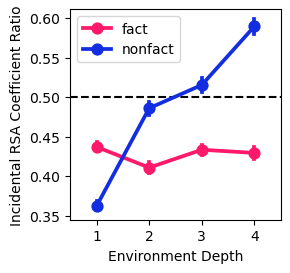

In [150]:
idx = rsa_results['freq'] == 'uniform'
plot_rsa(
    rsa_results.loc[idx],
    hue = 'pairs',
    palette = ['#fe196b', '#122ee0']
)

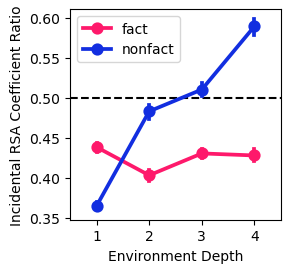

In [151]:
idx = rsa_results['freq'] == 'nonuniform'
plot_rsa(
    rsa_results.loc[idx],
    hue = 'pairs',
    palette = ['#fe196b', '#122ee0']
)

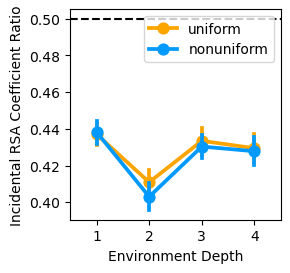

In [152]:
idx = rsa_results['pairs'] == 'fact'
plot_rsa(
    rsa_results.loc[idx],
    hue = 'freq',
    palette = ['#fca500', '#009afe']
)

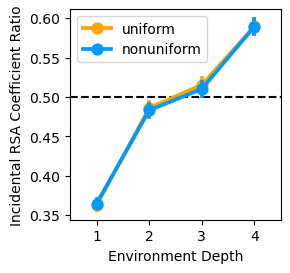

In [153]:
idx = rsa_results['pairs'] == 'nonfact'
plot_rsa(
    rsa_results.loc[idx],
    hue = 'freq',
    palette = ['#fca500', '#009afe']
)

### Get incidental vs true information weight

In [12]:
def get_M_masks(key, representations):
     feats = []
     for lab in representations[key]['row_labels']:
          if len(lab) == (int(representations[key]['edim']) + 1):
              lab = lab.replace('10', 'a')
          feats.append([i != '0' for i in lab])
     feats = np.array(feats)
     true_mask = feats@feats.T
     incidental_mask = np.logical_not(true_mask)
     np.fill_diagonal(true_mask, False)
     return true_mask, incidental_mask

In [13]:
# Get incidental weights for each model and agent
incidental_weights = []
n_agents = int(len(representations)/len(MODELS))
for model in MODELS:
    for i in range(1, n_agents + 1):

        # Get within- (true) and between-feature (incidental) masks
        true_mask, incidental_mask = get_M_masks((model, i), representations)

        # Sum information in true vs incidental regions of M
        M = representations[model, i]['M']
        true_sum = np.sum(M[true_mask])
        incidental_sum = np.sum(M[incidental_mask])
        true_max = np.max(M[true_mask])
        incidental_max = np.max(M[incidental_mask])

        # Get ratio of incidental to true information
        incidental_weight = incidental_sum/(true_sum + incidental_sum)
        incidental_max_weight = incidental_max/(true_max + incidental_max)

        # Add to DataFrame
        incidental_weights.append({
            'id': i,
            'model_label': model,
            'incidental_weight': incidental_weight,
            'incidental_max_weight': incidental_max_weight
        })

# Convert to data frame
incidental_weights_df = pd.DataFrame(incidental_weights)

# Add discount information
incidental_weights_df = pd.merge(
    incidental_weights_df,
    subj_df,
    on = ['model_label', 'id']
)
incidental_weights_df

,id,model_label,incidental_weight,incidental_max_weight,sdim,depth,freq,pairs,bias,alpha,beta,gamma
0,1,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.500000,0.500000,2,3,uniform,fact,none,0.915756,3.064588,1
1,2,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.499902,0.428508,2,3,uniform,fact,none,0.076919,0.288123,1
2,3,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.500515,0.500000,2,3,uniform,fact,none,0.511257,0.169620,1
3,4,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.500000,0.500000,2,3,uniform,fact,none,0.787134,3.364638,1
4,5,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.500585,0.496917,2,3,uniform,fact,none,0.280061,0.075533,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12995,246,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.657686,0.403423,2,4,nonuniform,nonfact,none,0.331801,0.176469,1
12996,247,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.669104,0.452380,2,4,nonuniform,nonfact,none,0.608630,1.901817,1
12997,248,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.665040,0.477216,2,4,nonuniform,nonfact,none,0.766325,1.586999,1
12998,249,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.648947,0.397374,2,4,nonuniform,nonfact,none,0.212342,0.150630,1


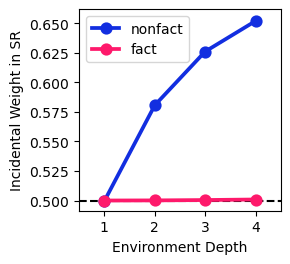

In [24]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['freq'] == 'uniform') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'pairs',
    palette = ['#122ee0', '#fe196b'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

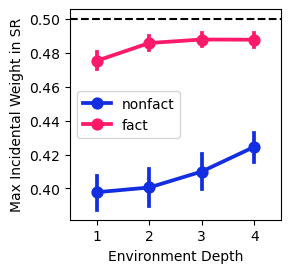

In [25]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['freq'] == 'uniform') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'pairs',
    palette = ['#122ee0', '#fe196b'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Max Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

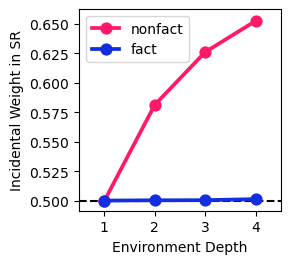

In [158]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['freq'] == 'nonuniform') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'pairs',
    palette = ['#fe196b', '#122ee0'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

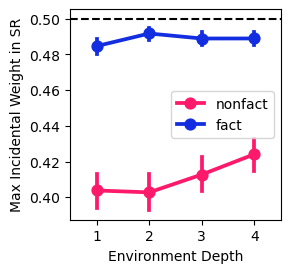

In [159]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['freq'] == 'nonuniform') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'pairs',
    palette = ['#fe196b', '#122ee0'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Max Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

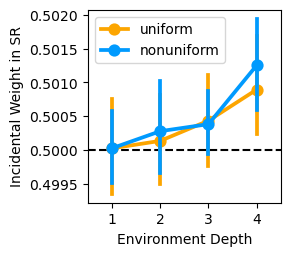

In [160]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['pairs'] == 'fact') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'freq',
    palette = ['#fca500', '#009afe'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

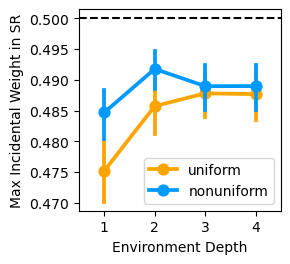

In [161]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['pairs'] == 'fact') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'freq',
    palette = ['#fca500', '#009afe'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Max Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

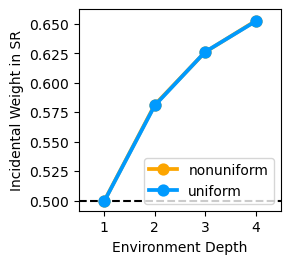

In [162]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['pairs'] == 'nonfact') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_weight',
    hue = 'freq',
    palette = ['#fca500', '#009afe'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

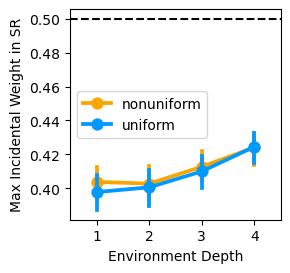

In [163]:
idx = (
    (incidental_weights_df['sdim'] == '2') &
    (incidental_weights_df['pairs'] == 'nonfact') &
    (incidental_weights_df['bias'] == 'none')
)
incidental_weights_df['depth'] = incidental_weights_df['depth'].astype(int)
fig, ax = plt.subplots(figsize=(3, 3))
ax.axhline(.5, color='black', linestyle='--', zorder=0)
sns.pointplot(
    data = incidental_weights_df.loc[idx],
    x = 'depth',
    y = 'incidental_max_weight',
    hue = 'freq',
    palette = ['#fca500', '#009afe'],
    ax = ax
)
ax.legend()
ax.set_xlabel('Environment Depth')
ax.set_ylabel('Max Incidental Weight in SR')
set_axis_ratio(ax)
fig.tight_layout()

# Training Analysis

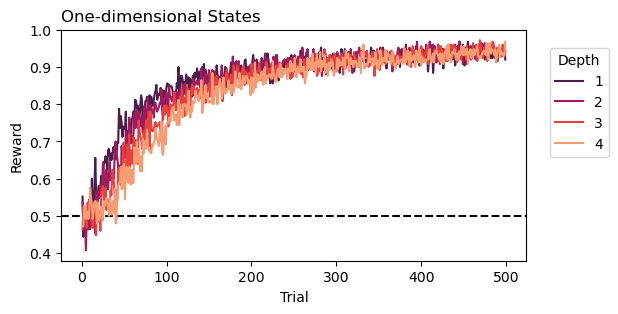

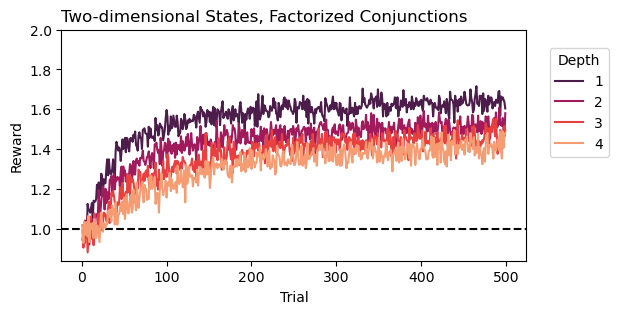

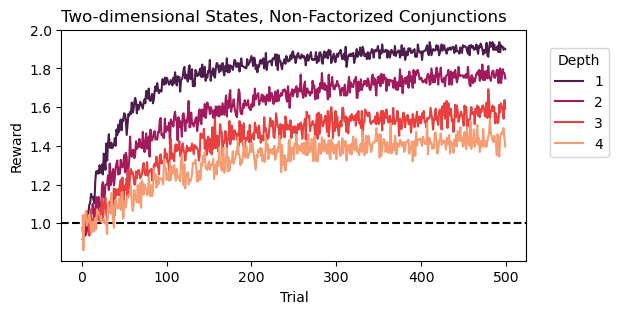

In [26]:
idx = (
    (training_df['sdim'] == '1') &
    (training_df['freq'] == 'uniform') &
    (training_df['bias'] == 'none') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'One-dimensional States',
    palette = sns.color_palette('rocket', 4)
)



idx = (
    (training_df['sdim'] == '2') &
    (training_df['freq'] == 'uniform') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'Two-dimensional States, Factorized Conjunctions',
    palette = sns.color_palette('rocket', 4)
)


idx = (
    (training_df['sdim'] == '2') &
    (training_df['freq'] == 'uniform') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'Two-dimensional States, Non-Factorized Conjunctions',
    palette = sns.color_palette('rocket', 4)
)


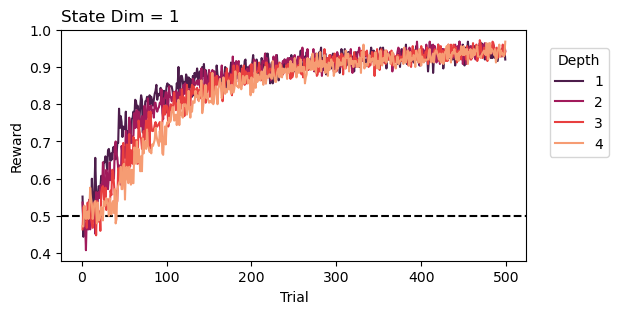

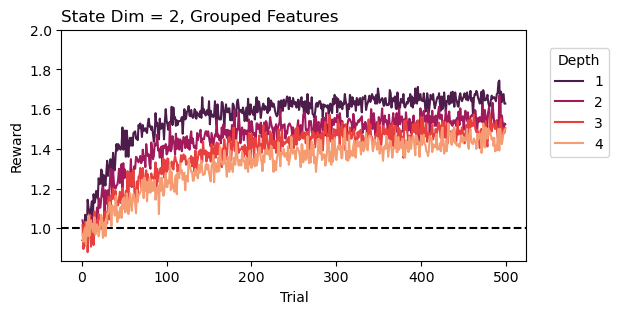

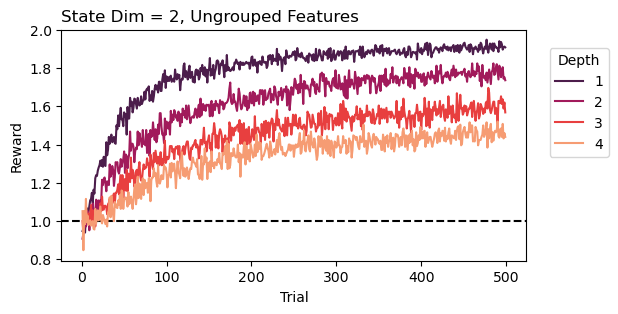

In [143]:
idx = (
    (training_df['sdim'] == '1') &
    #(training_df['freq'] == 'nonuniform') &
    (training_df['bias'] == 'none') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 1',
    palette = sns.color_palette('rocket', 4)
)



idx = (
    (training_df['sdim'] == '2') &
    (training_df['freq'] == 'nonuniform') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 2, Grouped Features',
    palette = sns.color_palette('rocket', 4)
)


idx = (
    (training_df['sdim'] == '2') &
    (training_df['freq'] == 'nonuniform') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['trial'] < 500)
)
training_df['depth'] = training_df['depth'].astype(int)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'depth',
    legend_title = 'Depth',
    title = 'State Dim = 2, Ungrouped Features',
    palette = sns.color_palette('rocket', 4)
)


In [15]:
idx = training_df['freq'] == 'uniform'
training_df['target_freq_label'] = training_df['freq_target'].replace(
    {1: 'Frequent', 0: 'Infrequent'}
)
training_df.loc[idx, 'target_freq_label'] = 'Uniform'

FREQUENCY_COLORS = {
    'Uniform': 'grey',
    'Infrequent': '#4CC9F0',
    'Frequent': '#F72585'
}

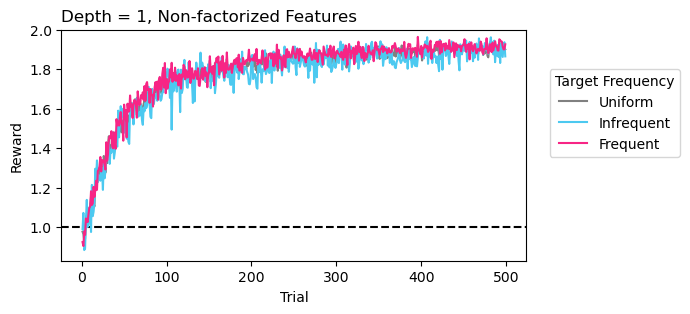

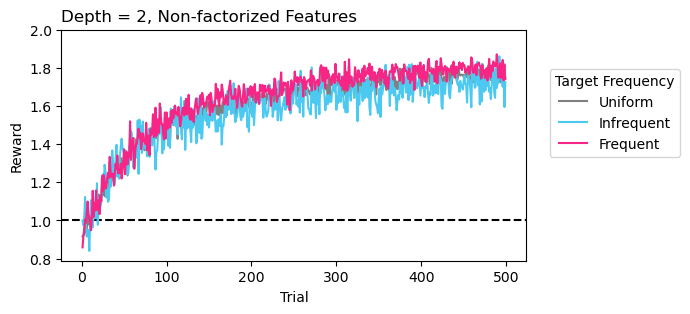

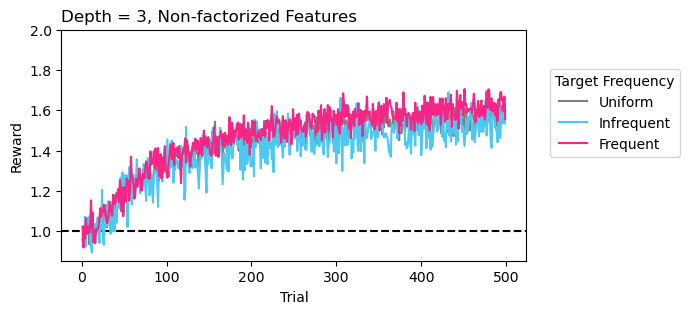

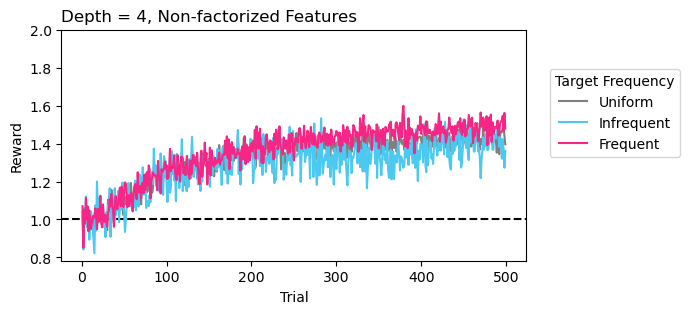

In [26]:
idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['depth'] == '1') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 1, Non-factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['depth'] == '2') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 2, Non-factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['depth'] == '3') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 3, Non-factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'nonfact') &
    (training_df['depth'] == '4') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 4, Non-factorized Features',
)

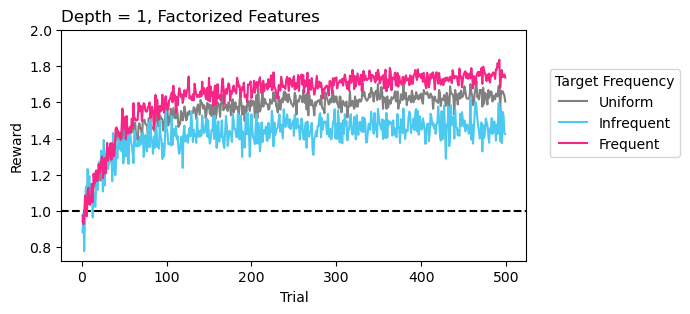

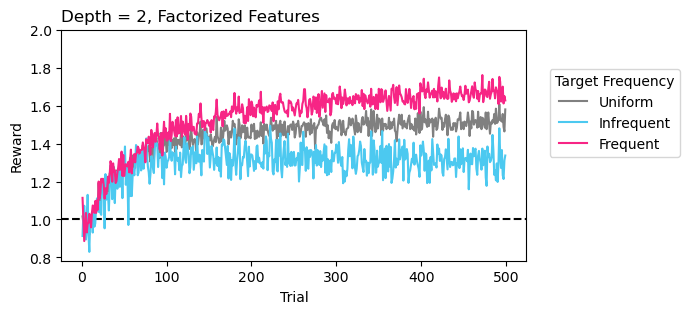

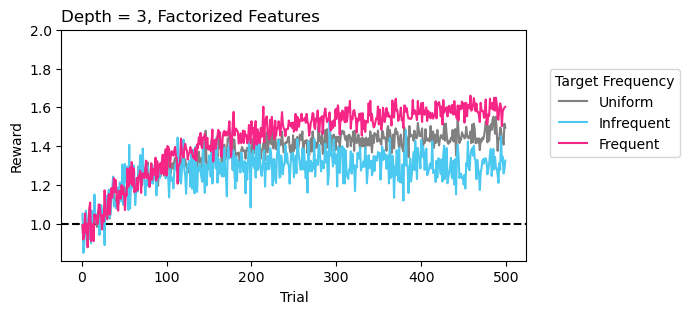

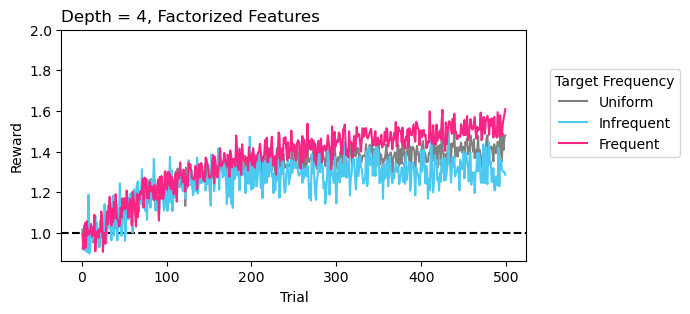

In [27]:
idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['depth'] == '1') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 1, Factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['depth'] == '2') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 2, Factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['depth'] == '3') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 3, Factorized Features',
)

idx = (
    (training_df['sdim'] == '2') &
    (training_df['bias'] == 'none') &
    (training_df['pairs'] == 'fact') &
    (training_df['depth'] == '4') &
    (training_df['trial'] < 500)
)
plot_training_curve(
    training_df.loc[idx],
    'reward',
    'target_freq_label',
    palette = FREQUENCY_COLORS,
    hue_order = ['Uniform', 'Infrequent', 'Frequent'],
    legend_title = 'Target Frequency',
    title = 'Depth = 4, Factorized Features',
)

In [104]:
# Label test targets/options as old (from training) or new
for model in MODELS:

    # Get targets and options seen during training
    idx = training_df['model_label'] == model
    training_targets = np.unique(training_df.loc[idx, 'target'])
    training_options = np.unique(training_df.loc[idx, 'options_comb'])

    # Label test targets and options as old or novel
    idx = test_df['model_label'] == model
    test_df.loc[idx, 'novel_target'] = np.isin(
        test_df.loc[idx, 'target'],
        training_targets,
        invert = True
    ).astype(int)
    test_df.loc[idx, 'novel_options'] = np.isin(
        test_df.loc[idx, 'options_comb'],
        training_options,
        invert = True
    ).astype(int)



In [106]:
# Get trials where options and target features match
test_df['options_target_comb_match'] = (
    test_df['options_comb'] == test_df['target_comb']
).astype(int)

# Label tesdt trials that would have been seen during training
test_df['old'] = (
    np.logical_not(test_df['novel_target']) &
    np.logical_not(test_df['novel_options']) &
    test_df['options_target_comb_match']
).astype(int)

In [108]:

# Get max points possible for each trial
target_combs = [convert_str_to_array(s) for s in test_df['target_comb']]
options_combs = [convert_str_to_array(s) for s in test_df['options_comb']]
target_combs = np.array(target_combs)
options_combs = np.array(options_combs)
test_df['max_reward'] = np.sum(
    (target_combs == options_combs) &
    (target_combs == 1),
    axis=1)

In [129]:
idx = (
    (test_df['target'] == '[1 0 0 1]') &
    (test_df['pairs'] == 'fact')
)
test_df.loc[idx, ['novel_target', 'options_target_comb_match']]

,novel_target,options_target_comb_match
12,1,0
36,1,0
60,1,1
84,1,0
108,1,0
...,...,...
1687892,1,0
1687916,1,1
1687940,1,0
1687964,1,0


In [127]:
test_df['novel_target'] = test_df['novel_target'].astype(int)
test_df['novel_options'] = test_df['novel_options'].astype(int)

0          0
1          0
2          0
3          0
4          0
          ..
1759995    0
1759996    0
1759997    0
1759998    0
1759999    0
Name: options_target_comb_match, Length: 1760000, dtype: int64

In [113]:

test_freq_df = pd.merge(
    test_df.loc[test_df['old'] == 1],
    training_df[[
        'id',
        'model_label',
        'target',
        'freq_target',
        'target_freq_label'
    ]].drop_duplicates(),
    on = ['id', 'model_label', 'target']
)
test_freq_df

,id,model_label,alpha,alpha_decay,beta,beta_test,gamma,segmentation,inference_inhibition,conjunctive_starts,...,depth,freq,pairs,novel_target,novel_options,options_target_comb_match,old,max_reward,freq_target,target_freq_label
0,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,3,uniform,fact,0.0,0.0,1,1,2,1,Uniform
1,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,3,uniform,fact,0.0,0.0,1,1,2,1,Uniform
2,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,3,uniform,fact,0.0,0.0,1,1,2,1,Uniform
3,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,3,uniform,fact,0.0,0.0,1,1,2,1,Uniform
4,150,model-ff_bias-none_sdim-2_depth-3_freq-uniform...,0.746698,0,0.086250,0.086250,1,0,1.207824,False,...,3,uniform,fact,0.0,0.0,1,1,2,1,Uniform
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,4,nonuniform,nonfact,0.0,0.0,1,1,2,0,Infrequent
199996,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,4,nonuniform,nonfact,0.0,0.0,1,1,2,0,Infrequent
199997,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,4,nonuniform,nonfact,0.0,0.0,1,1,2,1,Frequent
199998,149,model-ff_bias-none_sdim-2_depth-4_freq-nonunif...,0.678304,0,0.355193,0.355193,1,0,2.730594,False,...,4,nonuniform,nonfact,0.0,0.0,1,1,2,1,Frequent


In [ ]:
id_vars = [
    'id',
    'model_label',
    'target_freq_label',
    'old',
    'novel_target',
    'novel_options',
    'options_target_comb_match',
    'max_reward'
]
test_summary_df = test_df[[*id_vars, 'reward']].groupby(id_vars)
test_summary_df = test_summary_df.mean()
test_summary_df = test_summary_df.dropna()
test_summary_df = test_summary_df.reset_index()
test_summary_df = pd.merge(
    test_summary_df,
    subj_df,
    on = ['id', 'model_label']
)
test_summary_df

In [130]:
id_vars = [
    'id',
    'model_label',
    'old',
    'novel_target',
    'novel_options',
    'options_target_comb_match',
    'max_reward'
]
test_summary_df = test_df[[*id_vars, 'reward']].groupby(id_vars)
test_summary_df = test_summary_df.mean()
test_summary_df = test_summary_df.dropna()
test_summary_df = test_summary_df.reset_index()
test_summary_df = pd.merge(
    test_summary_df,
    subj_df,
    on = ['id', 'model_label']
)
test_summary_df

,id,model_label,old,novel_target,novel_options,options_target_comb_match,max_reward,reward,sdim,depth,freq,pairs,bias,alpha,beta,gamma
0,1,model-ff_bias-incidental_sdim-2_depth-1_freq-n...,0,0,0,0,0,0.00000,2,1,nonuniform,fact,incidental,0.915756,3.064588,1
1,1,model-ff_bias-incidental_sdim-2_depth-1_freq-n...,0,0,1,0,1,0.43750,2,1,nonuniform,fact,incidental,0.915756,3.064588,1
2,1,model-ff_bias-incidental_sdim-2_depth-1_freq-n...,0,1,0,0,1,0.46875,2,1,nonuniform,fact,incidental,0.915756,3.064588,1
3,1,model-ff_bias-incidental_sdim-2_depth-1_freq-n...,0,1,1,0,0,0.00000,2,1,nonuniform,fact,incidental,0.915756,3.064588,1
4,1,model-ff_bias-incidental_sdim-2_depth-1_freq-n...,0,1,1,0,1,0.56250,2,1,nonuniform,fact,incidental,0.915756,3.064588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61995,250,model-ff_bias-true_sdim-2_depth-4_freq-uniform...,0,1,1,1,2,2.00000,2,4,uniform,fact,true,0.230505,1.012939,1
61996,250,model-ff_bias-true_sdim-2_depth-4_freq-uniform...,1,0,0,1,2,2.00000,2,4,uniform,fact,true,0.230505,1.012939,1
61997,250,model-ff_bias-true_sdim-2_depth-4_freq-uniform...,0,0,0,0,0,0.00000,2,4,uniform,nonfact,true,0.230505,1.012939,1
61998,250,model-ff_bias-true_sdim-2_depth-4_freq-uniform...,0,0,0,0,1,1.00000,2,4,uniform,nonfact,true,0.230505,1.012939,1


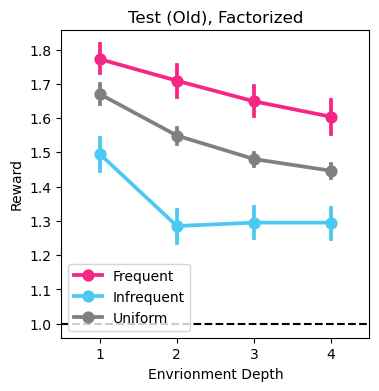

In [ ]:
idx = (
    (test_summary_df['sdim'] == '2') &
    (test_summary_df['bias'] == 'none') &
    (test_summary_df['pairs'] == 'fact') &
    (test_summary_df['old'] == 1)
)

fig, ax = plt.subplots(figsize=(4, 4))
ax.axhline(1, color='black', linestyle='--')
sns.pointplot(
    data = test_summary_df.loc[idx],
    x = 'depth',
    y = 'reward',
    hue = 'target_freq_label',
    palette = FREQUENCY_COLORS,
    ax = ax
)
ax.set_title('Test (Old), Factorized')
ax.set_xlabel('Envrionment Depth')
ax.set_ylabel('Reward')
ax.legend()
set_axis_ratio(ax)

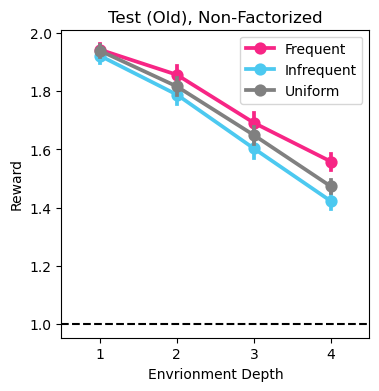

In [42]:
idx = (
    (test_summary_df['sdim'] == '2') &
    (test_summary_df['bias'] == 'none') &
    (test_summary_df['pairs'] == 'nonfact') &
    (test_summary_df['old'] == 1)
)

fig, ax = plt.subplots(figsize=(4, 4))
ax.axhline(1, color='black', linestyle='--')
sns.pointplot(
    data = test_summary_df.loc[idx],
    x = 'depth',
    y = 'reward',
    hue = 'target_freq_label',
    palette = FREQUENCY_COLORS,
    ax = ax
)
ax.set_title('Test (Old), Non-Factorized')
ax.set_xlabel('Envrionment Depth')
ax.set_ylabel('Reward')
ax.legend()
set_axis_ratio(ax)

In [30]:
test_summary_df = pd.merge(
    test_summary_df,
    rsa_results[['id', 'model_label', 'incidental_ratio']]
)
test_summary_df.head()

,id,model_label,target_freq_label,old,novel_target,novel_options,options_target_comb_match,max_reward,reward,sdim,depth,freq,pairs,bias,alpha,beta,gamma,incidental_ratio
0,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,Frequent,0,0.0,0.0,0,0,0.00,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.305099
1,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,Frequent,0,0.0,0.0,0,0,0.00,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.305099
2,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,Frequent,0,0.0,1.0,0,1,0.75,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.305099
3,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,Frequent,0,0.0,1.0,0,1,0.75,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.305099
4,1,model-ff_bias-none_sdim-2_depth-1_freq-nonunif...,Frequent,1,0.0,0.0,1,2,1.50,2,1,nonuniform,fact,none,0.915756,3.064588,1,0.305099


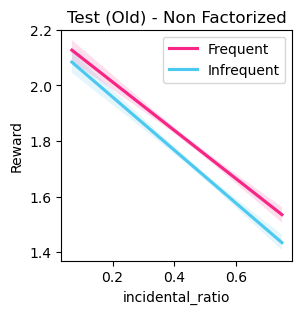

In [44]:
fig, ax = plt.subplots(figsize=(3, 3))

idx = (
    (test_summary_df['sdim'] == '2') &
    (test_summary_df['freq'] == 'nonuniform') &
    (test_summary_df['old'] == 1) &
    (test_summary_df['pairs'] == 'nonfact') &
    (test_summary_df['target_freq_label'] == 'Frequent') 
)
sns.regplot(
    data = test_summary_df.loc[idx],
    x = 'incidental_ratio',
    y = 'reward',
    scatter = False,
    label = 'Frequent',
    color = FREQUENCY_COLORS['Frequent'],
    ax = ax
)

idx = (
    (test_summary_df['sdim'] == '2') &
    (test_summary_df['freq'] == 'nonuniform') &
    (test_summary_df['old'] == 1) &
    (test_summary_df['pairs'] == 'nonfact') &
    (test_summary_df['target_freq_label'] == 'Infrequent') 
)
sns.regplot(
    data = test_summary_df.loc[idx],
    x = 'incidental_ratio',
    y = 'reward',
    scatter = False,
    label = 'Infrequent',
    color = FREQUENCY_COLORS['Infrequent'],
    ax = ax
)

ax.set_ylabel('Reward')
ax.set_title('Test (Old) - Non Factorized')
ax.legend()
set_axis_ratio(ax)

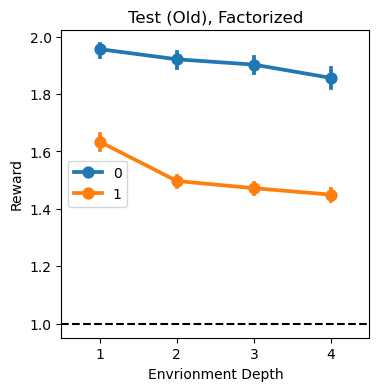

In [133]:
idx = (
    (test_summary_df['sdim'] == '2') &
    (test_summary_df['bias'] == 'none') &
    (test_summary_df['freq'] == 'nonuniform') &
    (test_summary_df['pairs'] == 'fact') &
    test_summary_df['options_target_comb_match']
)

fig, ax = plt.subplots(figsize=(4, 4))
ax.axhline(1, color='black', linestyle='--')
sns.pointplot(
    data = test_summary_df.loc[idx],
    x = 'depth',
    y = 'reward',
    hue = 'old',
    ax = ax
)
ax.set_title('Test (Old), Factorized')
ax.set_xlabel('Envrionment Depth')
ax.set_ylabel('Reward')
ax.legend()
set_axis_ratio(ax)

<Axes: xlabel='old', ylabel='p'>

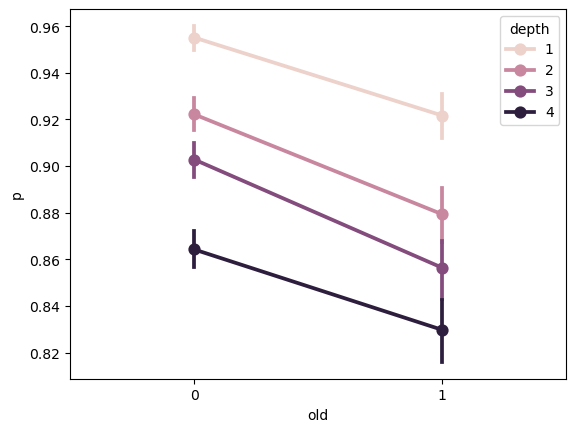

In [98]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'p',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

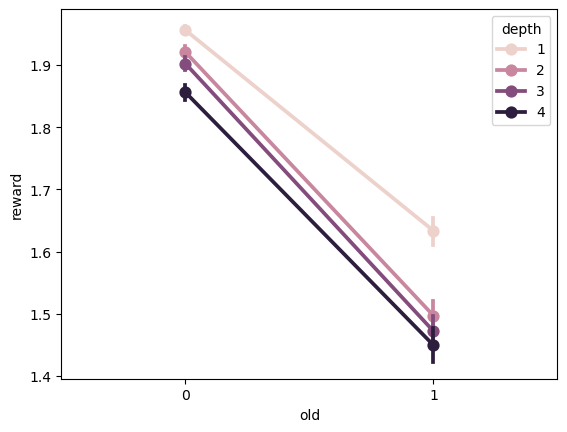

In [99]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='p'>

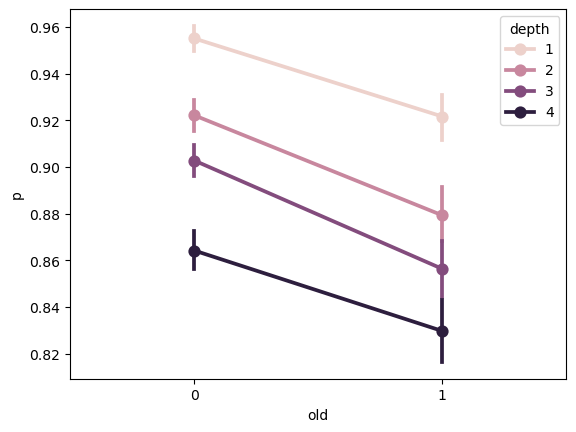

In [230]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'p',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

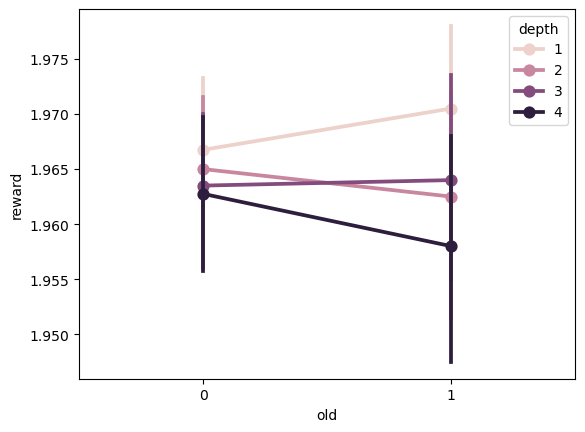

In [224]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

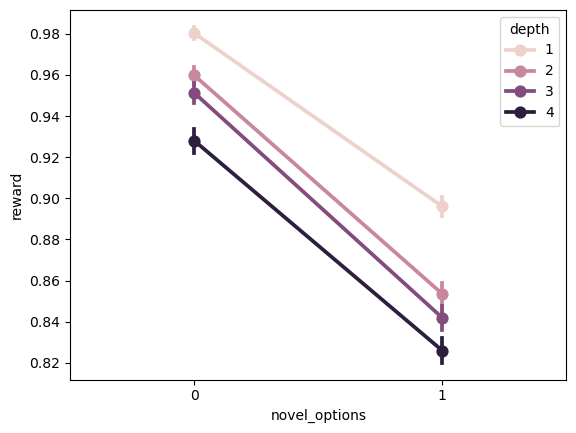

In [206]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform') &
    (test_df['max_reward'] == 1)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

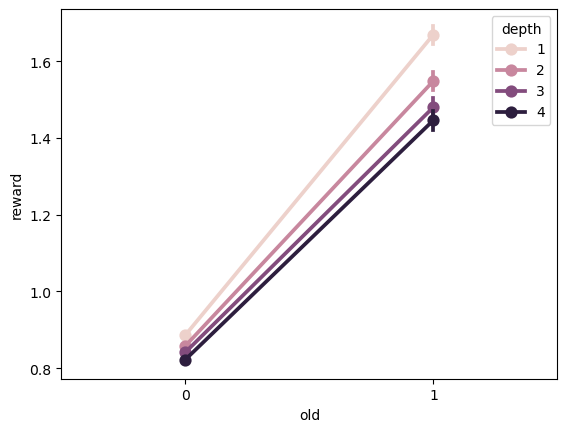

In [120]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='options_target_comb_match', ylabel='reward'>

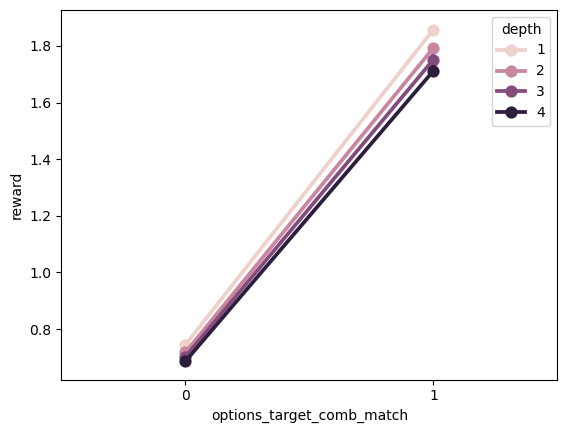

In [126]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'options_target_comb_match',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

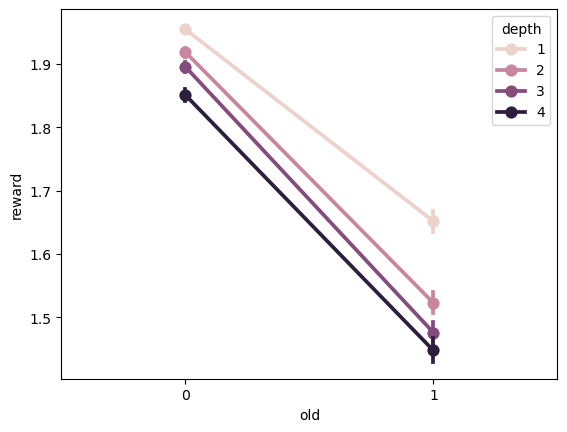

In [184]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    test_df['options_target_comb_match']
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

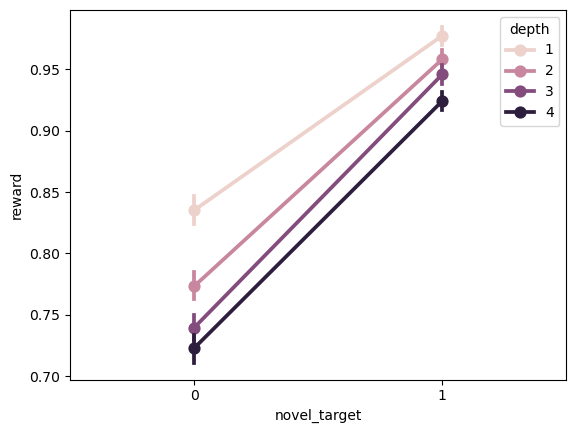

In [123]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

In [182]:
test_df.loc[idx, 'novel_target']

20         0
21         0
22         0
23         0
120        0
          ..
1463879    0
1463976    0
1463977    0
1463978    0
1463979    0
Name: novel_target, Length: 8000, dtype: object

<Axes: xlabel='novel_options', ylabel='reward'>

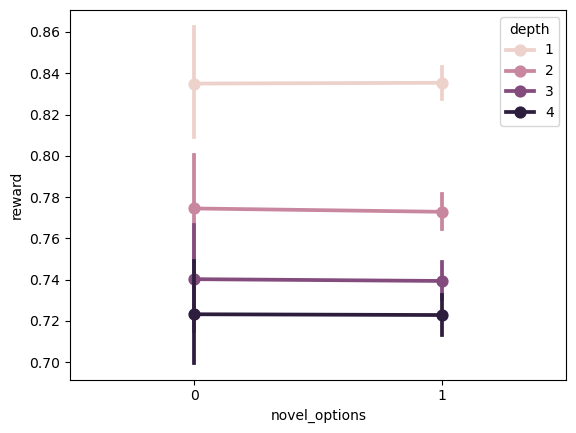

In [186]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

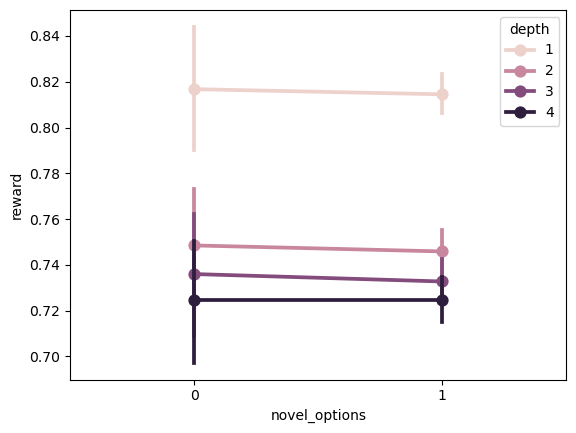

In [187]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform') &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

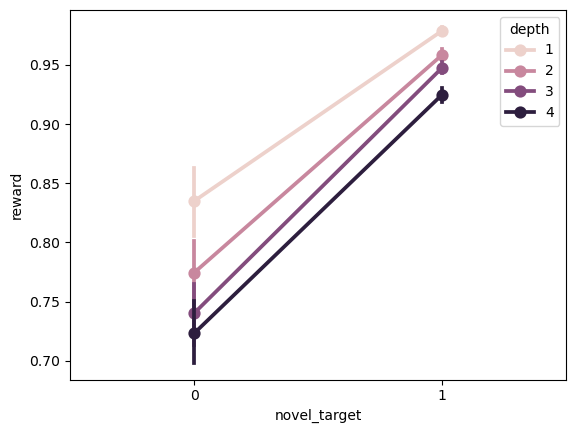

In [195]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') &
    np.logical_not(test_df['novel_options']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

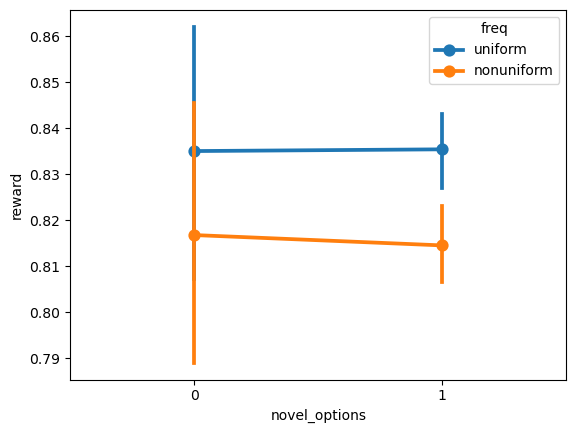

In [191]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 1) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

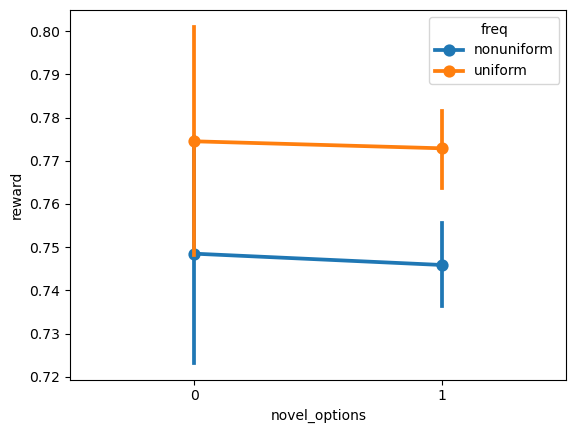

In [192]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 2) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

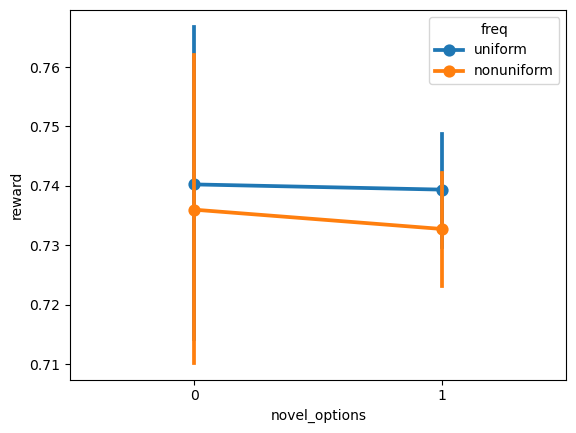

In [193]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 3) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

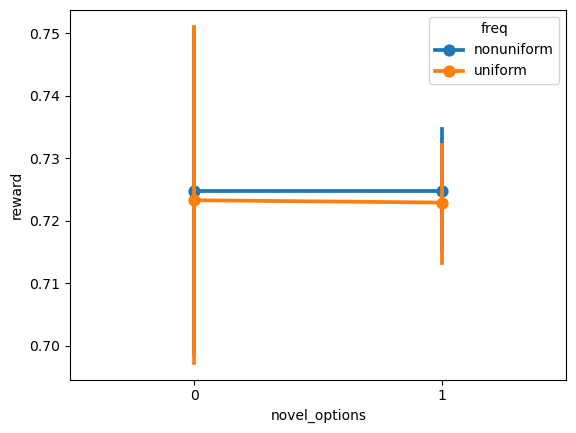

In [194]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 4) &
    np.logical_not(test_df['novel_target']) 
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_options', ylabel='reward'>

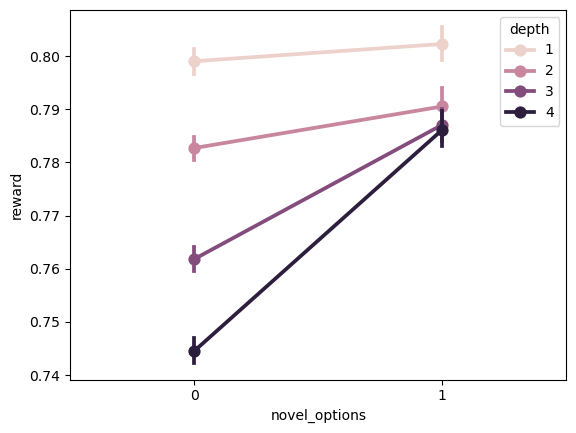

In [124]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform') 
)

sns.pointplot(
    data = test_df,
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

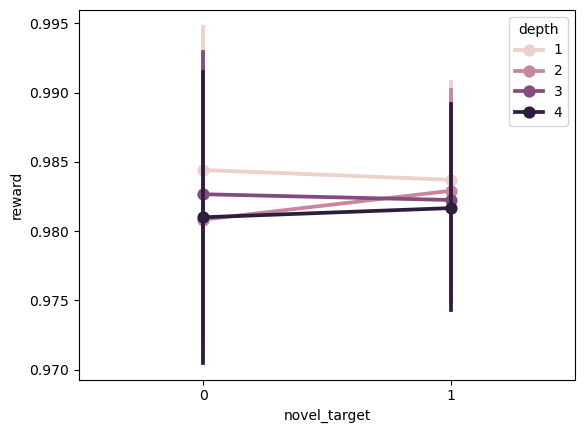

In [65]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

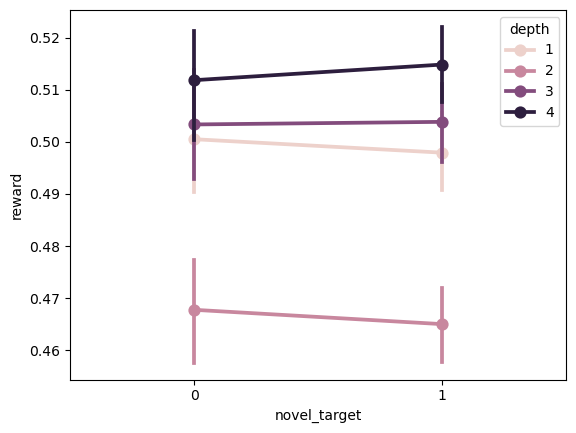

In [66]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

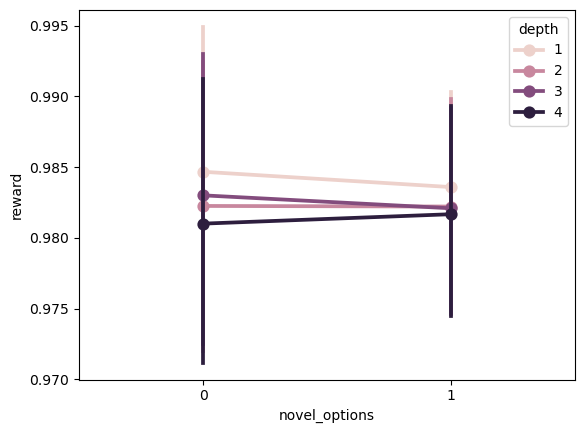

In [67]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

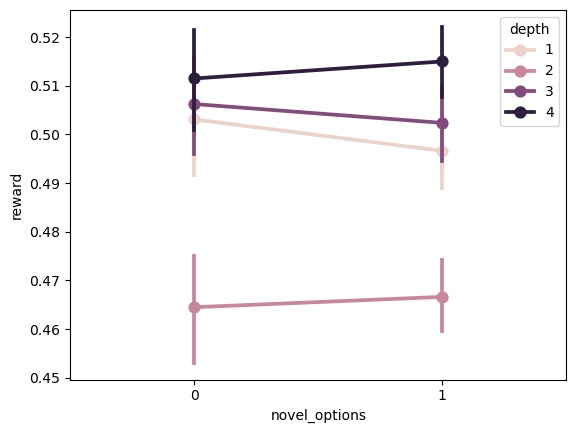

In [68]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'uniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='old', ylabel='reward'>

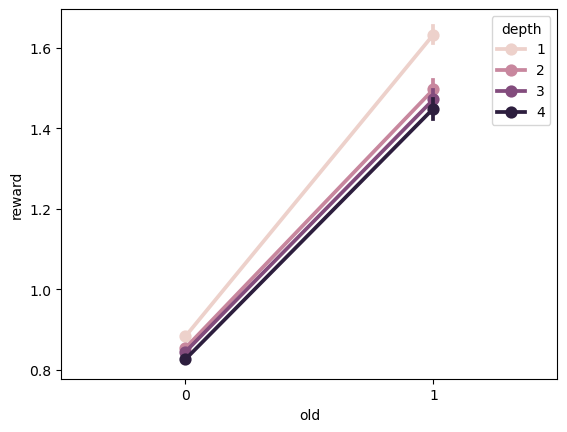

In [121]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact')  &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'old',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

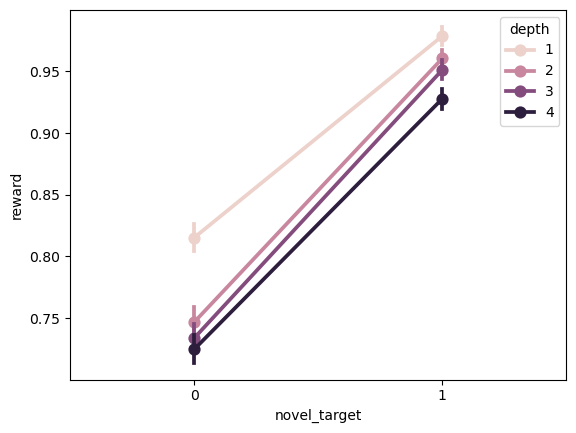

In [60]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

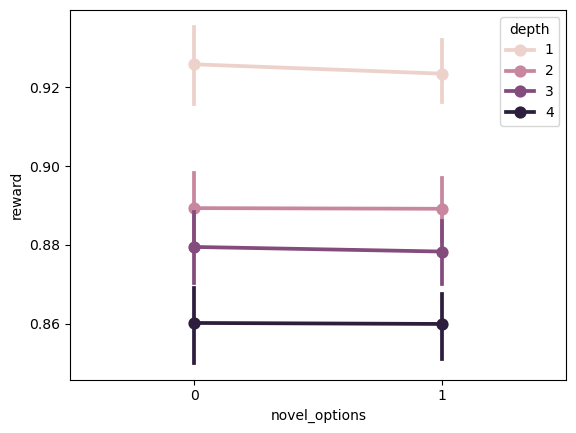

In [61]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

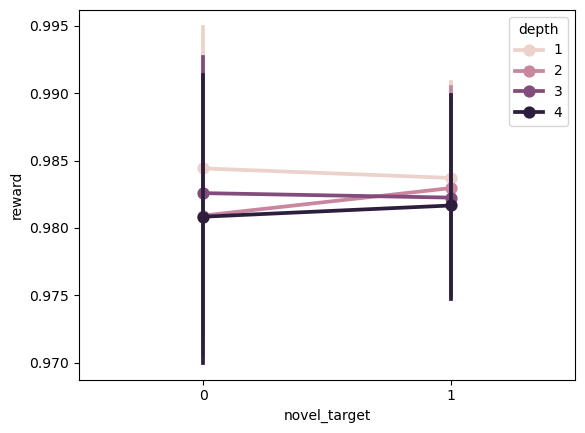

In [69]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

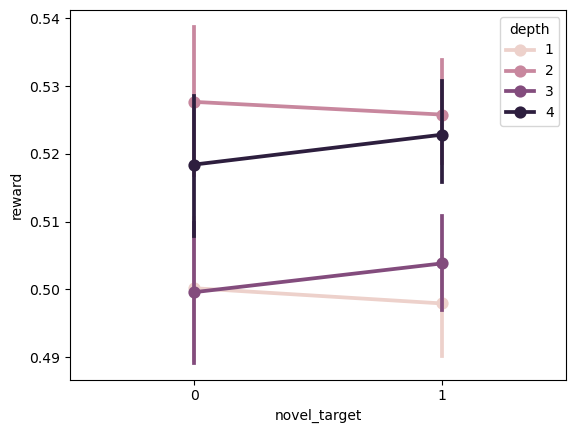

In [70]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

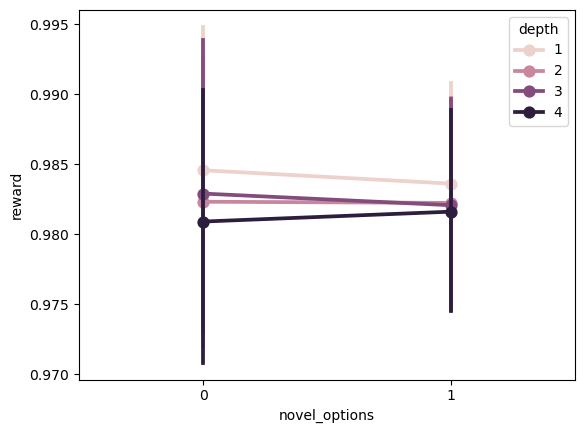

In [71]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'true') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_options', ylabel='reward'>

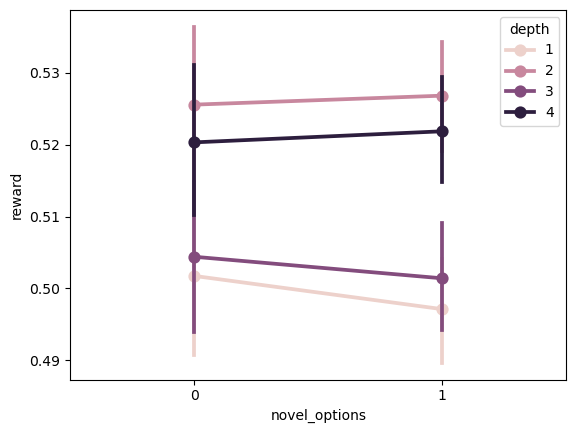

In [72]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'incidental') &
    (test_df['pairs'] == 'fact') &
    (test_df['freq'] == 'nonuniform')
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_options',
    y = 'reward',
    hue = 'depth'
)

<Axes: xlabel='novel_target', ylabel='reward'>

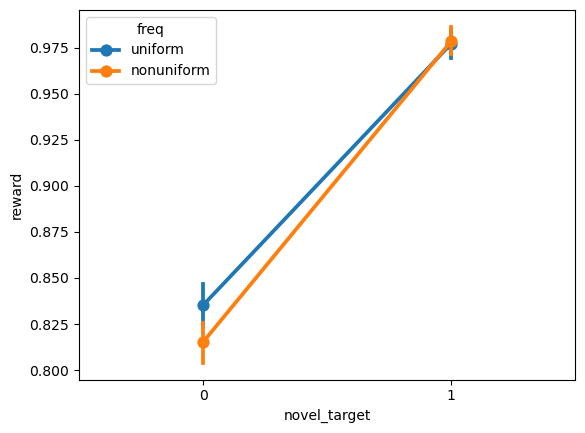

In [81]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 1)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

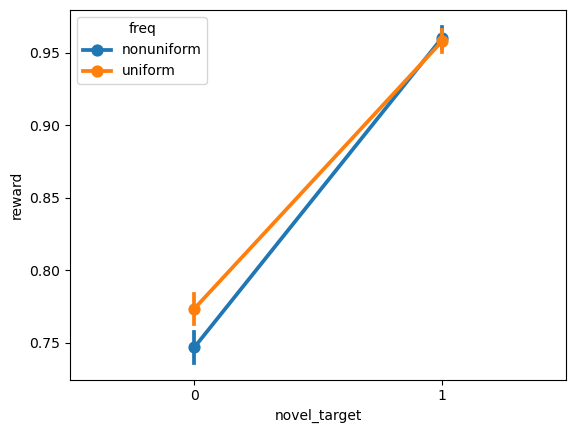

In [76]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 2)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

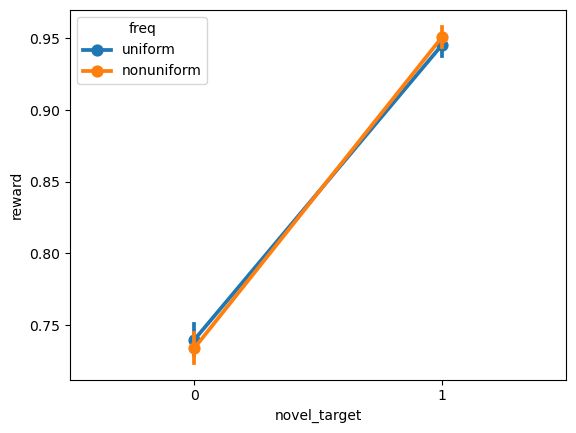

In [77]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 3)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

<Axes: xlabel='novel_target', ylabel='reward'>

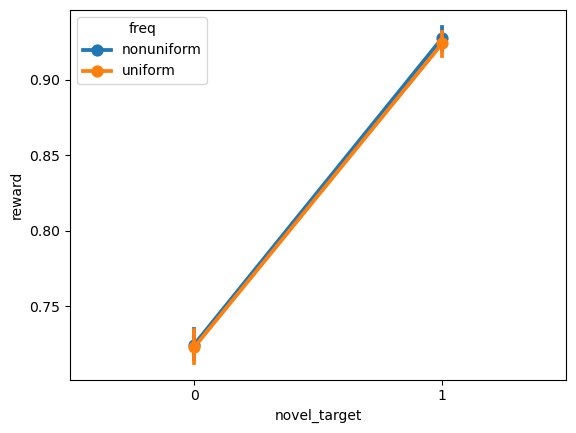

In [78]:
idx = (
    (test_df['sdim'] == '2') &
    (test_df['bias'] == 'none') &
    (test_df['pairs'] == 'fact') &
    (test_df['depth'] == 4)
)

sns.pointplot(
    data = test_df.loc[idx],
    x = 'novel_target',
    y = 'reward',
    hue = 'freq'
)

### Transition Influence

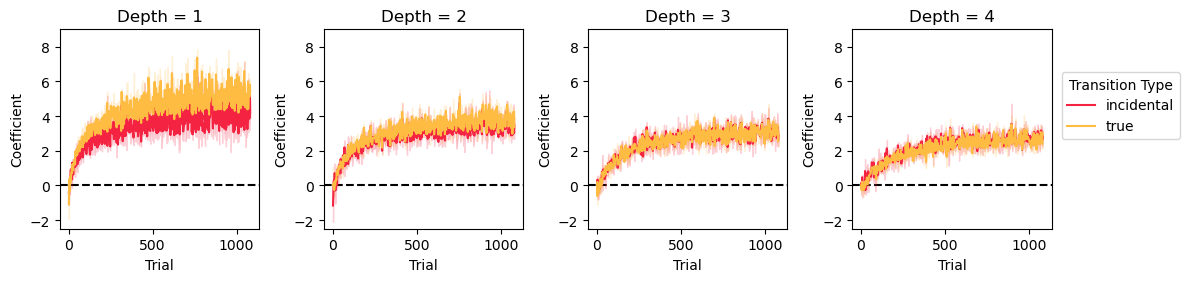

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'uniform') &
        (trans_influence_trial_df['pairs'] == 'fact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

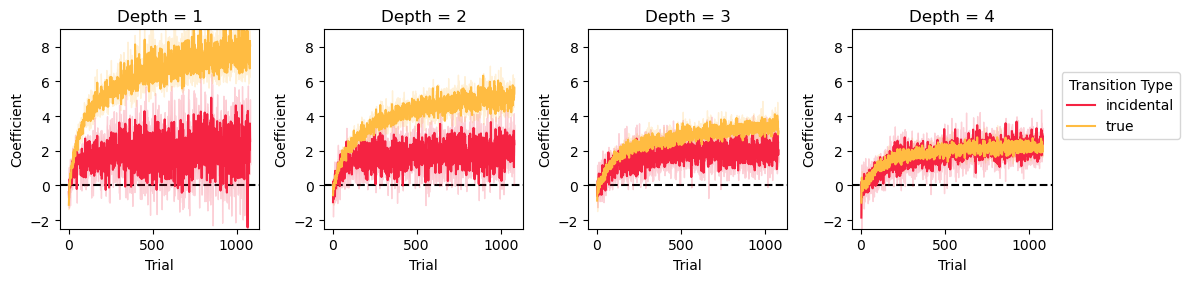

In [16]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'uniform') &
        (trans_influence_trial_df['pairs'] == 'nonfact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

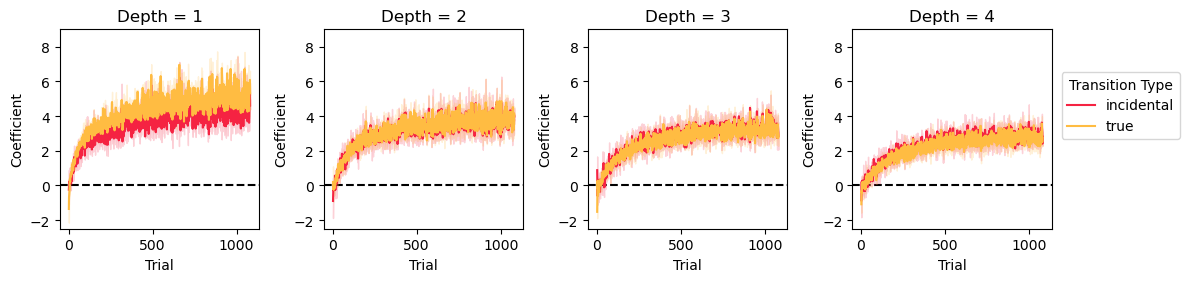

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'nonuniform') &
        (trans_influence_trial_df['pairs'] == 'fact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

/var/folders/d9/5q7mq_bn55x0t3cnmcd02v1w0000gn/T/ipykernel_57402/1305245321.py:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


AttributeError: 'NoneType' object has no attribute 'remove'

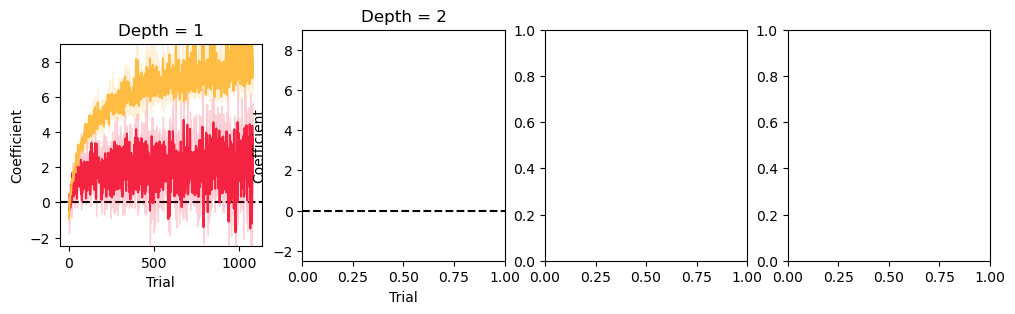

In [18]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i, depth in enumerate(['1', '2', '3', '4']):
    ax = axs[i]
    idx = (
        (trans_influence_trial_df['depth'] == depth) &
        (trans_influence_trial_df['freq'] == 'nonuniform') &
        (trans_influence_trial_df['pairs'] == 'nonfact') 
    )
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Depth = {depth}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 3:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type', loc=(1.05, .45))
fig.tight_layout()

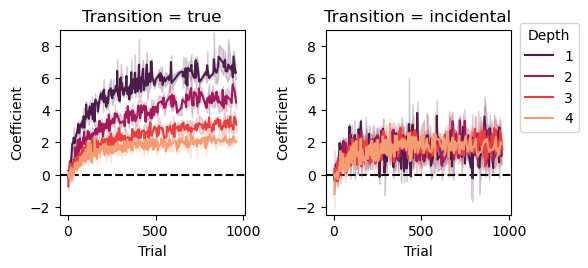

In [90]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
for i, transition in enumerate(['true', 'incidental']):
    ax = axs[i]
    idx = trans_influence_trial_df['transition'] == transition
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.lineplot(
        data = trans_influence_trial_df.loc[idx],
        x = 'trial',
        y = 'coef',
        hue = 'depth',
        palette = 'rocket',
        ax = ax
    )
    ax.set_ylim(-2.5, 9)
    ax.set_title(f'Transition = {transition}')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Coefficient')
    if i < 1:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Depth', loc=(1.05, .45))
fig.tight_layout()

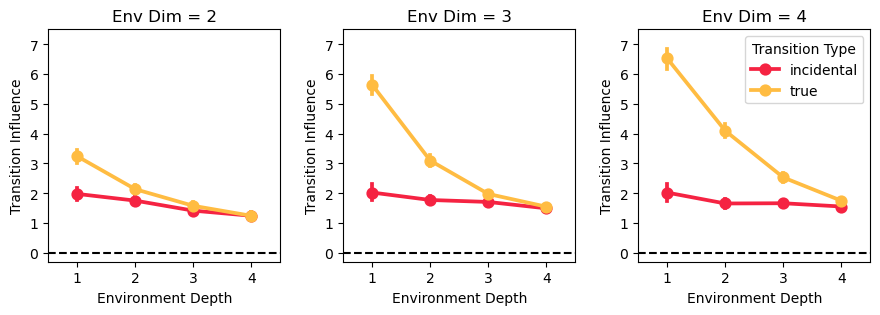

In [26]:
plot_df = trans_influence_df[['id', 'edim', 'depth', 'transition', 'coef']]
plot_df = plot_df.groupby(['id', 'edim', 'depth', 'transition'])
plot_df = plot_df.mean().reset_index()

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, edim in enumerate(['2', '3', '4']):
    ax = axs[i]
    idx = plot_df['edim'] == edim
    ax.axhline(0, color='black', linestyle='--', zorder=0)
    sns.pointplot(
        data = plot_df.loc[idx],
        x = 'depth',
        y = 'coef',
        hue = 'transition',
        palette = TRANSITION_INFLUENCE_COLORS,
        ax = ax
    )
    ax.set_ylim(-.3, 7.5)
    ax.set_title(f'Env Dim = {edim}')
    ax.set_xlabel('Environment Depth')
    ax.set_ylabel('Transition Influence')
    if i < 2:
        ax.get_legend().remove()
    set_axis_ratio(ax)
ax.legend(title='Transition Type')
fig.tight_layout()